# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

In [4]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Choose the device
device = torch.device("cuda:0" if cuda_available else "cpu")

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [5]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """
    Transforms to apply to the image.
    
    Args:
        size (Tuple[int, int]): Desired output size of the image.

    Returns:
        Callable: A composition of transformations.
    """
    # TODO: edit this function by appending transforms to the below list
    transforms = [Resize(size),
                  ToTensor(),
                 Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [6]:
import os

class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        
        # list of images IMG
        self.images = self.__getfiles__()

    def __getfiles__(self) -> list:
        jpg_files = []
        files = os.listdir(self.directory)
        for file in files:
            if file.lower().endswith(self.extension):
                file_path = os.path.join(self.directory, file)
                image = Image.open(file_path)
                jpg_files.append(image)
        return jpg_files
            
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return self.images.__len__()

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        image = self.images[index]
        return self.transforms(image)

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

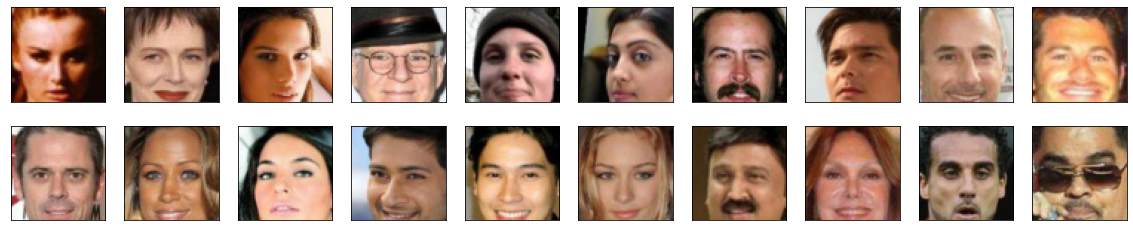

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [9]:
from torch.nn import Module, Conv2d
from torch.nn import BatchNorm2d, LeakyReLU, Flatten, Linear, Dropout

In [10]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: 
        Conv -> BatchNorm -> Activation
    Args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch_norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = BatchNorm2d(out_channels)
        self.activation = LeakyReLU(0.3)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [11]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        
        conv_dim = 64
        self.conv1 = ConvBlock(3, out_channels=conv_dim, kernel_size=4, batch_norm=False)
        self.conv2 = ConvBlock(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4)
        self.conv3 = ConvBlock(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4)
        self.conv4 = ConvBlock(in_channels=conv_dim*4, out_channels=conv_dim*8, kernel_size=4)
        
        self.flatten = Flatten()
        
        # Final, fully-connected layer
        self.fc = Linear(conv_dim*4*4*4*2, 1)
        # Add model regularization, i.e. dropout layer
        self.dropout = Dropout(0.3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        # Apply horizontal flipping with a 50% probability during training
        if self.training and torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[3])  # Flip along the width dimension
            
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # flatten and dropout
        x = self.flatten(x)
        x = self.dropout(x)
        
        # final output layer
        x = self.fc(x)
        return x.view(1, 1, 1, -1)

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
from torch.nn import ConvTranspose2d, ReLU, Tanh

In [14]:
class DeconvBlock(Module):
    """
    A "de-convolutional" block is made of 3 layers:
        ConvTranspose -> BatchNorm -> Activation
    args:
    - in-channels: number of channels in the input to the conv layer
    - out-channels: number of filters in the input to the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self,
                in_channels: int,
                out_channels: int,
                kernel_size: int,
                stride: int,
                padding: int,
                batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        
        if self.batch_norm:
            self.bn = BatchNorm2d(out_channels)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        return x

In [15]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()

        conv_dim = 64
        # TODO: instantiate the different layers
        # transpose the conv layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*8, kernel_size=4, stride=1, padding=0)
        self.deconv2 = DeconvBlock(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1)
        self.deconv3 = DeconvBlock(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1)
        self.deconv4 = DeconvBlock(conv_dim*2, conv_dim, kernel_size=4, stride=2, padding=1)
        self.deconv5 = DeconvBlock(conv_dim, 3, kernel_size=4, stride=2, padding=1, batch_norm=False)
        
        self.relu = ReLU()
        self.tanh = Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.relu(self.deconv4(x))
        x = self.tanh(self.deconv5(x))
        return x

In [16]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [17]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    # params
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999 # DEFAULT VALUE

    g_optimizer = optim.Adam(generator.parameters(), lr, (beta1, beta2))
    d_optimizer = optim.Adam(discriminator.parameters(), lr, (beta1, beta2))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [18]:
from torch.nn import BCEWithLogitsLoss

In [19]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss

    # BCEWithLogitsLoss()
    labels = torch.ones_like(fake_logits).cuda()
    
    criterion = BCEWithLogitsLoss()
    loss = criterion(fake_logits, labels)
    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [20]:
def discriminator_loss(real_logits, fake_logits, smooth=True):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss

    real_labels = torch.ones_like(real_logits).cuda()  # all real labels are ones
    fake_labels = torch.zeros_like(fake_logits).cuda() # all fake labels are zeros

    if smooth:
        real_labels *= .9
    
    criterion = BCEWithLogitsLoss()
    
    r_loss = criterion(real_logits, real_labels)
    f_loss = criterion(fake_logits, fake_labels)
    
    loss = r_loss + f_loss
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [21]:
import torch.autograd as autograd

def gradient_penalty(discriminator, real_samples, fake_samples, device=device):
    """ This function enforces the Lipschitz constraint using gradient penalty. """
    batch_size = real_samples.size(0)
    
    # Generate random epsilon values between 0 and 1
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    epsilon = epsilon.expand_as(real_samples)
    
    # Create interpolated samples
    interpolated_samples = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolated_samples = autograd.Variable(interpolated_samples, requires_grad=True)
    
    # Calculate the discriminator's scores for the interpolated samples
    interpolated_logits = discriminator(interpolated_samples)
    
    # Calculate the gradients of the interpolated scores with respect to the samples
    gradients = autograd.grad(outputs=interpolated_logits, inputs=interpolated_samples,
                              grad_outputs=torch.ones_like(interpolated_logits),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    # Calculate the gradient penalty term
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    gp = torch.max(torch.tensor(0.0, device=device), (gradients_norm - 1) ** 2).mean()
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [22]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    
    # Generate random latent vectors
    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    
    # Generate fake samples using the generator
    fake_samples = generator(z)
    
    # Pass the fake samples through the discriminator
    fake_logits = discriminator(fake_samples)
    
    # Calculate the generator loss
    g_loss = generator_loss(fake_logits)
    
    # Backpropagation and optimization
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    
    # Generate random latent vectors
    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    
    # Generate fake samples using the generator
    fake_samples = generator(z)
    
    # Calculate the discriminator's scores for real and fake samples
    real_logits = discriminator(real_images)
    fake_logits = discriminator(fake_samples.detach())  # Detach to avoid gradients from generator
    
    # Calculate the discriminator loss
    d_loss = discriminator_loss(real_logits, fake_logits)
    
    # Calculate the gradient penalty
    gp = gradient_penalty(discriminator, real_images, fake_samples)
    
    # Add gradient penalty to the discriminator loss
    lambda_gp = 0.5 # Smaller lambda_gp put less emphasis on the gradient penalty compared to the adversarial loss
    d_loss += lambda_gp * gp
    
    # Backpropagation and optimization
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [23]:
from datetime import datetime

In [24]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
# device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [26]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-08-06 03:51:57 | Epoch [1/20] | Batch 0/509 | d_loss: 1.7175 | g_loss: 2.4656
2023-08-06 03:52:02 | Epoch [1/20] | Batch 50/509 | d_loss: 2.9727 | g_loss: 8.5251
2023-08-06 03:52:08 | Epoch [1/20] | Batch 100/509 | d_loss: 1.8867 | g_loss: 2.6251
2023-08-06 03:52:13 | Epoch [1/20] | Batch 150/509 | d_loss: 1.1040 | g_loss: 0.4857
2023-08-06 03:52:18 | Epoch [1/20] | Batch 200/509 | d_loss: 2.4043 | g_loss: 3.0541
2023-08-06 03:52:24 | Epoch [1/20] | Batch 250/509 | d_loss: 2.0411 | g_loss: 1.6808
2023-08-06 03:52:29 | Epoch [1/20] | Batch 300/509 | d_loss: 0.8727 | g_loss: 1.6865
2023-08-06 03:52:35 | Epoch [1/20] | Batch 350/509 | d_loss: 1.3211 | g_loss: 1.1928
2023-08-06 03:52:41 | Epoch [1/20] | Batch 400/509 | d_loss: 1.2836 | g_loss: 1.5927
2023-08-06 03:52:47 | Epoch [1/20] | Batch 450/509 | d_loss: 1.1947 | g_loss: 1.5608
2023-08-06 03:52:52 | Epoch [1/20] | Batch 500/509 | d_loss: 1.2487 | g_loss: 1.3492


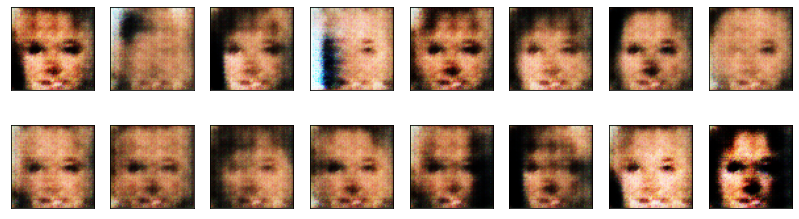

2023-08-06 03:52:57 | Epoch [2/20] | Batch 0/509 | d_loss: 1.7344 | g_loss: 2.6271
2023-08-06 03:53:03 | Epoch [2/20] | Batch 50/509 | d_loss: 0.8674 | g_loss: 0.4668
2023-08-06 03:53:09 | Epoch [2/20] | Batch 100/509 | d_loss: 0.9687 | g_loss: 1.4411
2023-08-06 03:53:15 | Epoch [2/20] | Batch 150/509 | d_loss: 1.1517 | g_loss: 1.4100
2023-08-06 03:53:20 | Epoch [2/20] | Batch 200/509 | d_loss: 1.5891 | g_loss: 2.8900
2023-08-06 03:53:26 | Epoch [2/20] | Batch 250/509 | d_loss: 1.4206 | g_loss: 1.7876
2023-08-06 03:53:32 | Epoch [2/20] | Batch 300/509 | d_loss: 1.3589 | g_loss: 0.9023
2023-08-06 03:53:37 | Epoch [2/20] | Batch 350/509 | d_loss: 1.2825 | g_loss: 1.3404
2023-08-06 03:53:43 | Epoch [2/20] | Batch 400/509 | d_loss: 1.0607 | g_loss: 1.6696
2023-08-06 03:53:49 | Epoch [2/20] | Batch 450/509 | d_loss: 1.4775 | g_loss: 1.3469
2023-08-06 03:53:55 | Epoch [2/20] | Batch 500/509 | d_loss: 1.0973 | g_loss: 1.5516


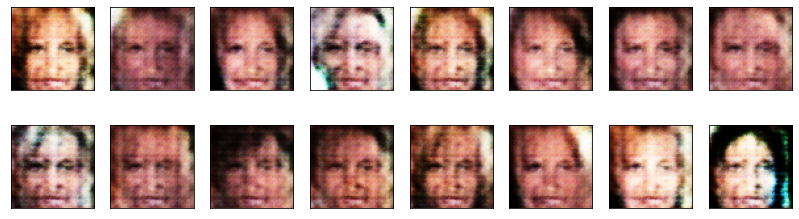

2023-08-06 03:54:00 | Epoch [3/20] | Batch 0/509 | d_loss: 1.4765 | g_loss: 1.3966
2023-08-06 03:54:05 | Epoch [3/20] | Batch 50/509 | d_loss: 1.2821 | g_loss: 1.0571
2023-08-06 03:54:11 | Epoch [3/20] | Batch 100/509 | d_loss: 1.5665 | g_loss: 1.4442
2023-08-06 03:54:17 | Epoch [3/20] | Batch 150/509 | d_loss: 1.1604 | g_loss: 1.0235
2023-08-06 03:54:22 | Epoch [3/20] | Batch 200/509 | d_loss: 1.3417 | g_loss: 1.3175
2023-08-06 03:54:28 | Epoch [3/20] | Batch 250/509 | d_loss: 1.3920 | g_loss: 1.0927
2023-08-06 03:54:34 | Epoch [3/20] | Batch 300/509 | d_loss: 0.9848 | g_loss: 1.5685
2023-08-06 03:54:40 | Epoch [3/20] | Batch 350/509 | d_loss: 1.2667 | g_loss: 1.4483
2023-08-06 03:54:45 | Epoch [3/20] | Batch 400/509 | d_loss: 1.1010 | g_loss: 1.2050
2023-08-06 03:54:51 | Epoch [3/20] | Batch 450/509 | d_loss: 1.4720 | g_loss: 1.1763
2023-08-06 03:54:57 | Epoch [3/20] | Batch 500/509 | d_loss: 1.1878 | g_loss: 1.1189


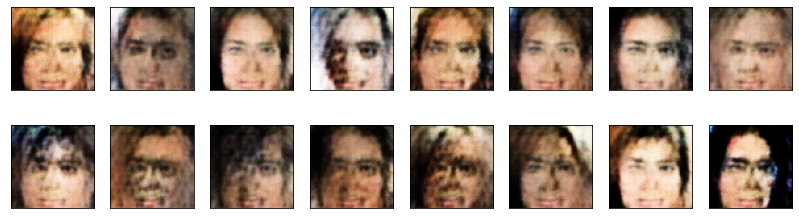

2023-08-06 03:55:02 | Epoch [4/20] | Batch 0/509 | d_loss: 1.1356 | g_loss: 0.6671
2023-08-06 03:55:08 | Epoch [4/20] | Batch 50/509 | d_loss: 1.4130 | g_loss: 1.1293
2023-08-06 03:55:14 | Epoch [4/20] | Batch 100/509 | d_loss: 1.3906 | g_loss: 1.4644
2023-08-06 03:55:20 | Epoch [4/20] | Batch 150/509 | d_loss: 1.0850 | g_loss: 0.6080
2023-08-06 03:55:25 | Epoch [4/20] | Batch 200/509 | d_loss: 1.2152 | g_loss: 0.6346
2023-08-06 03:55:31 | Epoch [4/20] | Batch 250/509 | d_loss: 1.2938 | g_loss: 1.1249
2023-08-06 03:55:37 | Epoch [4/20] | Batch 300/509 | d_loss: 1.4424 | g_loss: 1.3237
2023-08-06 03:55:43 | Epoch [4/20] | Batch 350/509 | d_loss: 1.2179 | g_loss: 0.9847
2023-08-06 03:55:49 | Epoch [4/20] | Batch 400/509 | d_loss: 1.2467 | g_loss: 1.1646
2023-08-06 03:55:54 | Epoch [4/20] | Batch 450/509 | d_loss: 1.3260 | g_loss: 0.8359
2023-08-06 03:56:00 | Epoch [4/20] | Batch 500/509 | d_loss: 1.1626 | g_loss: 0.6820


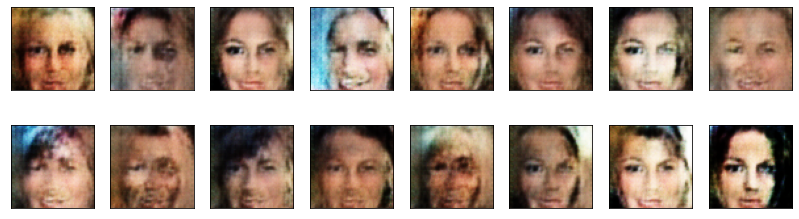

2023-08-06 03:56:04 | Epoch [5/20] | Batch 0/509 | d_loss: 1.2230 | g_loss: 0.9991
2023-08-06 03:56:10 | Epoch [5/20] | Batch 50/509 | d_loss: 1.4128 | g_loss: 1.2167
2023-08-06 03:56:16 | Epoch [5/20] | Batch 100/509 | d_loss: 1.2948 | g_loss: 1.2059
2023-08-06 03:56:21 | Epoch [5/20] | Batch 150/509 | d_loss: 1.4497 | g_loss: 0.9217
2023-08-06 03:56:27 | Epoch [5/20] | Batch 200/509 | d_loss: 1.2803 | g_loss: 1.2455
2023-08-06 03:56:33 | Epoch [5/20] | Batch 250/509 | d_loss: 1.2535 | g_loss: 1.2003
2023-08-06 03:56:39 | Epoch [5/20] | Batch 300/509 | d_loss: 1.2343 | g_loss: 0.8908
2023-08-06 03:56:44 | Epoch [5/20] | Batch 350/509 | d_loss: 1.4121 | g_loss: 1.0304
2023-08-06 03:56:50 | Epoch [5/20] | Batch 400/509 | d_loss: 1.3654 | g_loss: 1.1658
2023-08-06 03:56:56 | Epoch [5/20] | Batch 450/509 | d_loss: 1.3162 | g_loss: 1.1798
2023-08-06 03:57:01 | Epoch [5/20] | Batch 500/509 | d_loss: 1.2451 | g_loss: 0.7390


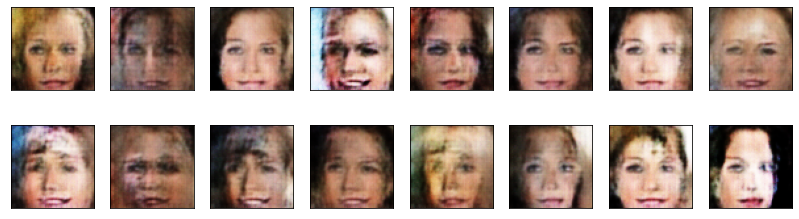

2023-08-06 03:57:06 | Epoch [6/20] | Batch 0/509 | d_loss: 1.7653 | g_loss: 1.8918
2023-08-06 03:57:11 | Epoch [6/20] | Batch 50/509 | d_loss: 1.1566 | g_loss: 0.7116
2023-08-06 03:57:17 | Epoch [6/20] | Batch 100/509 | d_loss: 1.3295 | g_loss: 1.0318
2023-08-06 03:57:23 | Epoch [6/20] | Batch 150/509 | d_loss: 1.2051 | g_loss: 0.7990
2023-08-06 03:57:28 | Epoch [6/20] | Batch 200/509 | d_loss: 1.4338 | g_loss: 0.9535
2023-08-06 03:57:34 | Epoch [6/20] | Batch 250/509 | d_loss: 1.0986 | g_loss: 0.5579
2023-08-06 03:57:40 | Epoch [6/20] | Batch 300/509 | d_loss: 1.3484 | g_loss: 1.0804
2023-08-06 03:57:46 | Epoch [6/20] | Batch 350/509 | d_loss: 1.2004 | g_loss: 1.3418
2023-08-06 03:57:51 | Epoch [6/20] | Batch 400/509 | d_loss: 1.3388 | g_loss: 0.9164
2023-08-06 03:57:57 | Epoch [6/20] | Batch 450/509 | d_loss: 1.4744 | g_loss: 1.2968
2023-08-06 03:58:03 | Epoch [6/20] | Batch 500/509 | d_loss: 1.3635 | g_loss: 0.9267


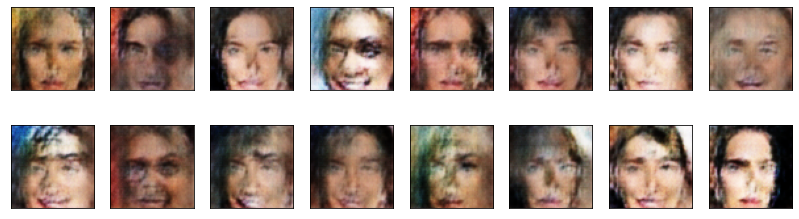

2023-08-06 03:58:08 | Epoch [7/20] | Batch 0/509 | d_loss: 1.3259 | g_loss: 0.9309
2023-08-06 03:58:13 | Epoch [7/20] | Batch 50/509 | d_loss: 1.0985 | g_loss: 0.5125
2023-08-06 03:58:19 | Epoch [7/20] | Batch 100/509 | d_loss: 1.2657 | g_loss: 1.0017
2023-08-06 03:58:25 | Epoch [7/20] | Batch 150/509 | d_loss: 1.0420 | g_loss: 0.4307
2023-08-06 03:58:31 | Epoch [7/20] | Batch 200/509 | d_loss: 1.3569 | g_loss: 0.9748
2023-08-06 03:58:36 | Epoch [7/20] | Batch 250/509 | d_loss: 1.2887 | g_loss: 1.0916
2023-08-06 03:58:42 | Epoch [7/20] | Batch 300/509 | d_loss: 1.7116 | g_loss: 0.9802
2023-08-06 03:58:48 | Epoch [7/20] | Batch 350/509 | d_loss: 1.2684 | g_loss: 1.0408
2023-08-06 03:58:53 | Epoch [7/20] | Batch 400/509 | d_loss: 1.2664 | g_loss: 0.8621
2023-08-06 03:58:59 | Epoch [7/20] | Batch 450/509 | d_loss: 1.2833 | g_loss: 0.9044
2023-08-06 03:59:05 | Epoch [7/20] | Batch 500/509 | d_loss: 1.3263 | g_loss: 0.9710


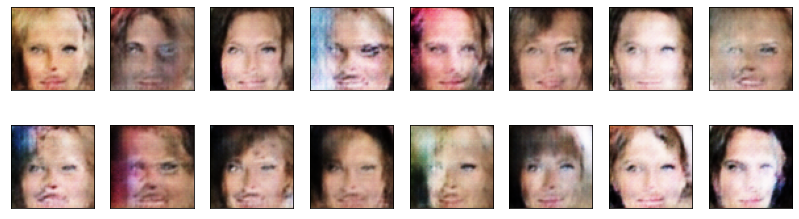

2023-08-06 03:59:10 | Epoch [8/20] | Batch 0/509 | d_loss: 1.4611 | g_loss: 1.7648
2023-08-06 03:59:16 | Epoch [8/20] | Batch 50/509 | d_loss: 1.2869 | g_loss: 1.1312
2023-08-06 03:59:21 | Epoch [8/20] | Batch 100/509 | d_loss: 1.2186 | g_loss: 1.0628
2023-08-06 03:59:27 | Epoch [8/20] | Batch 150/509 | d_loss: 1.2847 | g_loss: 1.1105
2023-08-06 03:59:33 | Epoch [8/20] | Batch 200/509 | d_loss: 1.2566 | g_loss: 0.9531
2023-08-06 03:59:39 | Epoch [8/20] | Batch 250/509 | d_loss: 1.2218 | g_loss: 0.8324
2023-08-06 03:59:44 | Epoch [8/20] | Batch 300/509 | d_loss: 1.3903 | g_loss: 1.5103
2023-08-06 03:59:50 | Epoch [8/20] | Batch 350/509 | d_loss: 1.0598 | g_loss: 1.0745
2023-08-06 03:59:56 | Epoch [8/20] | Batch 400/509 | d_loss: 1.5383 | g_loss: 2.0968
2023-08-06 04:00:02 | Epoch [8/20] | Batch 450/509 | d_loss: 1.0861 | g_loss: 0.4690
2023-08-06 04:00:07 | Epoch [8/20] | Batch 500/509 | d_loss: 1.2068 | g_loss: 0.9714


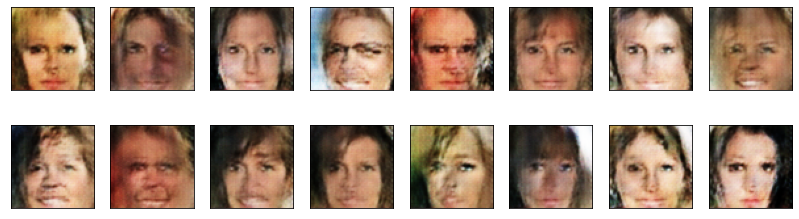

2023-08-06 04:00:13 | Epoch [9/20] | Batch 0/509 | d_loss: 1.3496 | g_loss: 1.0230
2023-08-06 04:00:19 | Epoch [9/20] | Batch 50/509 | d_loss: 1.1818 | g_loss: 0.8491
2023-08-06 04:00:25 | Epoch [9/20] | Batch 100/509 | d_loss: 1.2479 | g_loss: 1.2255
2023-08-06 04:00:30 | Epoch [9/20] | Batch 150/509 | d_loss: 1.1788 | g_loss: 0.6820
2023-08-06 04:00:36 | Epoch [9/20] | Batch 200/509 | d_loss: 1.1870 | g_loss: 0.8073
2023-08-06 04:00:42 | Epoch [9/20] | Batch 250/509 | d_loss: 1.2616 | g_loss: 0.9023
2023-08-06 04:00:47 | Epoch [9/20] | Batch 300/509 | d_loss: 1.2300 | g_loss: 1.0896
2023-08-06 04:00:53 | Epoch [9/20] | Batch 350/509 | d_loss: 1.1747 | g_loss: 0.8506
2023-08-06 04:00:59 | Epoch [9/20] | Batch 400/509 | d_loss: 1.3670 | g_loss: 0.9897
2023-08-06 04:01:05 | Epoch [9/20] | Batch 450/509 | d_loss: 1.2732 | g_loss: 1.2184
2023-08-06 04:01:10 | Epoch [9/20] | Batch 500/509 | d_loss: 1.3420 | g_loss: 1.1632


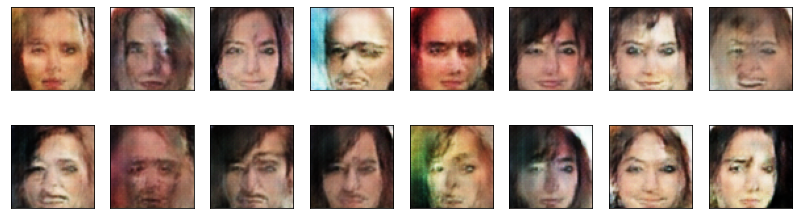

2023-08-06 04:01:15 | Epoch [10/20] | Batch 0/509 | d_loss: 1.0951 | g_loss: 1.1208
2023-08-06 04:01:21 | Epoch [10/20] | Batch 50/509 | d_loss: 1.2759 | g_loss: 1.0960
2023-08-06 04:01:27 | Epoch [10/20] | Batch 100/509 | d_loss: 1.5012 | g_loss: 1.1209
2023-08-06 04:01:32 | Epoch [10/20] | Batch 150/509 | d_loss: 1.2843 | g_loss: 1.0477
2023-08-06 04:01:38 | Epoch [10/20] | Batch 200/509 | d_loss: 1.5143 | g_loss: 1.8915
2023-08-06 04:01:44 | Epoch [10/20] | Batch 250/509 | d_loss: 1.1363 | g_loss: 0.8272
2023-08-06 04:01:50 | Epoch [10/20] | Batch 300/509 | d_loss: 1.2852 | g_loss: 1.0809
2023-08-06 04:01:55 | Epoch [10/20] | Batch 350/509 | d_loss: 1.4093 | g_loss: 1.1678
2023-08-06 04:02:01 | Epoch [10/20] | Batch 400/509 | d_loss: 1.2755 | g_loss: 1.0094
2023-08-06 04:02:07 | Epoch [10/20] | Batch 450/509 | d_loss: 1.0942 | g_loss: 0.5255
2023-08-06 04:02:13 | Epoch [10/20] | Batch 500/509 | d_loss: 1.1739 | g_loss: 0.8171


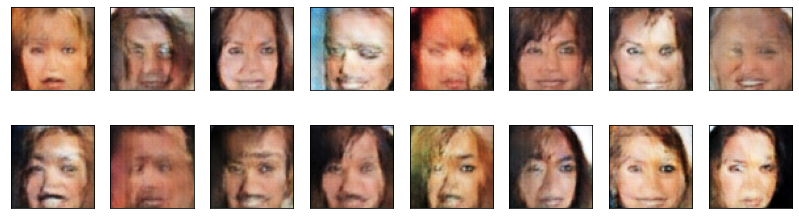

2023-08-06 04:02:17 | Epoch [11/20] | Batch 0/509 | d_loss: 1.3100 | g_loss: 1.0665
2023-08-06 04:02:23 | Epoch [11/20] | Batch 50/509 | d_loss: 1.4810 | g_loss: 1.0824
2023-08-06 04:02:28 | Epoch [11/20] | Batch 100/509 | d_loss: 1.2904 | g_loss: 0.9948
2023-08-06 04:02:34 | Epoch [11/20] | Batch 150/509 | d_loss: 1.5522 | g_loss: 0.9753
2023-08-06 04:02:40 | Epoch [11/20] | Batch 200/509 | d_loss: 1.3908 | g_loss: 0.8907
2023-08-06 04:02:46 | Epoch [11/20] | Batch 250/509 | d_loss: 1.1595 | g_loss: 0.5500
2023-08-06 04:02:51 | Epoch [11/20] | Batch 300/509 | d_loss: 1.5302 | g_loss: 1.2376
2023-08-06 04:02:57 | Epoch [11/20] | Batch 350/509 | d_loss: 1.3637 | g_loss: 1.1362
2023-08-06 04:03:03 | Epoch [11/20] | Batch 400/509 | d_loss: 1.3086 | g_loss: 0.8242
2023-08-06 04:03:08 | Epoch [11/20] | Batch 450/509 | d_loss: 1.2999 | g_loss: 1.0064
2023-08-06 04:03:14 | Epoch [11/20] | Batch 500/509 | d_loss: 1.2837 | g_loss: 0.9131


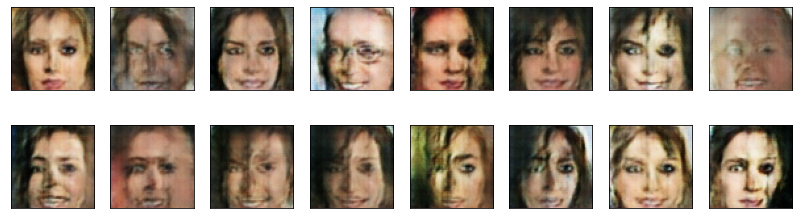

2023-08-06 04:03:19 | Epoch [12/20] | Batch 0/509 | d_loss: 1.0972 | g_loss: 0.6612
2023-08-06 04:03:25 | Epoch [12/20] | Batch 50/509 | d_loss: 1.6120 | g_loss: 1.8894
2023-08-06 04:03:31 | Epoch [12/20] | Batch 100/509 | d_loss: 1.1925 | g_loss: 1.1731
2023-08-06 04:03:36 | Epoch [12/20] | Batch 150/509 | d_loss: 1.2204 | g_loss: 0.9247
2023-08-06 04:03:42 | Epoch [12/20] | Batch 200/509 | d_loss: 1.1529 | g_loss: 0.7895
2023-08-06 04:03:48 | Epoch [12/20] | Batch 250/509 | d_loss: 1.3685 | g_loss: 1.1101
2023-08-06 04:03:54 | Epoch [12/20] | Batch 300/509 | d_loss: 1.2682 | g_loss: 1.0652
2023-08-06 04:04:00 | Epoch [12/20] | Batch 350/509 | d_loss: 1.2165 | g_loss: 1.2860
2023-08-06 04:04:05 | Epoch [12/20] | Batch 400/509 | d_loss: 1.4501 | g_loss: 1.3268
2023-08-06 04:04:11 | Epoch [12/20] | Batch 450/509 | d_loss: 1.6084 | g_loss: 1.0316
2023-08-06 04:04:17 | Epoch [12/20] | Batch 500/509 | d_loss: 1.3476 | g_loss: 0.7678


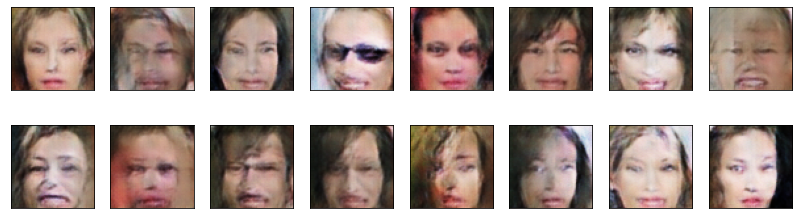

2023-08-06 04:04:21 | Epoch [13/20] | Batch 0/509 | d_loss: 1.1375 | g_loss: 0.7677
2023-08-06 04:04:27 | Epoch [13/20] | Batch 50/509 | d_loss: 1.3718 | g_loss: 1.0984
2023-08-06 04:04:33 | Epoch [13/20] | Batch 100/509 | d_loss: 1.3700 | g_loss: 0.9967
2023-08-06 04:04:38 | Epoch [13/20] | Batch 150/509 | d_loss: 1.3329 | g_loss: 0.8052
2023-08-06 04:04:44 | Epoch [13/20] | Batch 200/509 | d_loss: 1.2575 | g_loss: 0.9878
2023-08-06 04:04:50 | Epoch [13/20] | Batch 250/509 | d_loss: 1.2042 | g_loss: 0.9131
2023-08-06 04:04:55 | Epoch [13/20] | Batch 300/509 | d_loss: 1.3299 | g_loss: 0.8198
2023-08-06 04:05:01 | Epoch [13/20] | Batch 350/509 | d_loss: 1.2588 | g_loss: 0.7856
2023-08-06 04:05:07 | Epoch [13/20] | Batch 400/509 | d_loss: 1.2890 | g_loss: 1.2939
2023-08-06 04:05:12 | Epoch [13/20] | Batch 450/509 | d_loss: 1.3174 | g_loss: 0.8697
2023-08-06 04:05:18 | Epoch [13/20] | Batch 500/509 | d_loss: 1.1502 | g_loss: 0.6322


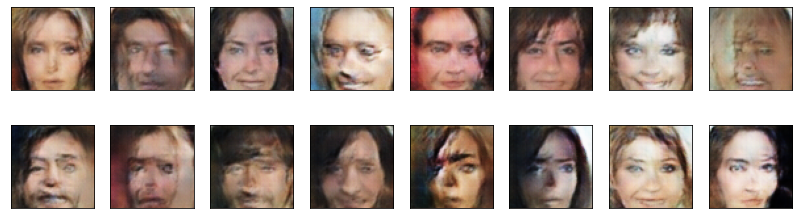

2023-08-06 04:05:23 | Epoch [14/20] | Batch 0/509 | d_loss: 1.2839 | g_loss: 1.0829
2023-08-06 04:05:29 | Epoch [14/20] | Batch 50/509 | d_loss: 1.3148 | g_loss: 0.9542
2023-08-06 04:05:34 | Epoch [14/20] | Batch 100/509 | d_loss: 1.1798 | g_loss: 1.0941
2023-08-06 04:05:40 | Epoch [14/20] | Batch 150/509 | d_loss: 1.4222 | g_loss: 1.1116
2023-08-06 04:05:46 | Epoch [14/20] | Batch 200/509 | d_loss: 1.2766 | g_loss: 1.0166
2023-08-06 04:05:51 | Epoch [14/20] | Batch 250/509 | d_loss: 1.2088 | g_loss: 0.7974
2023-08-06 04:05:57 | Epoch [14/20] | Batch 300/509 | d_loss: 1.2602 | g_loss: 1.1336
2023-08-06 04:06:03 | Epoch [14/20] | Batch 350/509 | d_loss: 1.4638 | g_loss: 0.8973
2023-08-06 04:06:09 | Epoch [14/20] | Batch 400/509 | d_loss: 1.2864 | g_loss: 0.7562
2023-08-06 04:06:14 | Epoch [14/20] | Batch 450/509 | d_loss: 1.2553 | g_loss: 0.9026
2023-08-06 04:06:20 | Epoch [14/20] | Batch 500/509 | d_loss: 1.2652 | g_loss: 0.8399


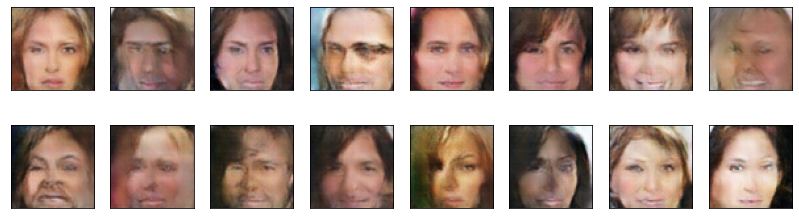

2023-08-06 04:06:25 | Epoch [15/20] | Batch 0/509 | d_loss: 1.3327 | g_loss: 1.1010
2023-08-06 04:06:31 | Epoch [15/20] | Batch 50/509 | d_loss: 1.2724 | g_loss: 1.0776
2023-08-06 04:06:37 | Epoch [15/20] | Batch 100/509 | d_loss: 1.3878 | g_loss: 1.1610
2023-08-06 04:06:43 | Epoch [15/20] | Batch 150/509 | d_loss: 1.4375 | g_loss: 0.9601
2023-08-06 04:06:48 | Epoch [15/20] | Batch 200/509 | d_loss: 1.2719 | g_loss: 0.9418
2023-08-06 04:06:54 | Epoch [15/20] | Batch 250/509 | d_loss: 1.2005 | g_loss: 1.1465
2023-08-06 04:07:00 | Epoch [15/20] | Batch 300/509 | d_loss: 1.2561 | g_loss: 1.1630
2023-08-06 04:07:06 | Epoch [15/20] | Batch 350/509 | d_loss: 1.2017 | g_loss: 1.0644
2023-08-06 04:07:11 | Epoch [15/20] | Batch 400/509 | d_loss: 1.1864 | g_loss: 1.1235
2023-08-06 04:07:17 | Epoch [15/20] | Batch 450/509 | d_loss: 1.4273 | g_loss: 1.2585
2023-08-06 04:07:23 | Epoch [15/20] | Batch 500/509 | d_loss: 1.3726 | g_loss: 1.1006


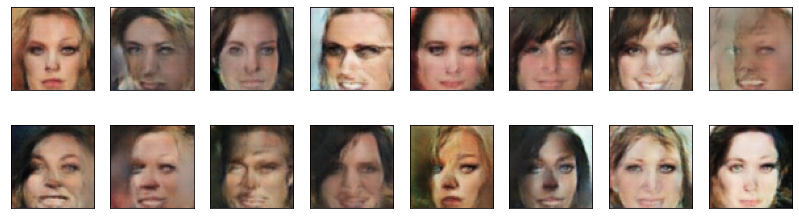

2023-08-06 04:07:29 | Epoch [16/20] | Batch 0/509 | d_loss: 1.2587 | g_loss: 1.1079
2023-08-06 04:07:35 | Epoch [16/20] | Batch 50/509 | d_loss: 1.1886 | g_loss: 1.1050
2023-08-06 04:07:40 | Epoch [16/20] | Batch 100/509 | d_loss: 1.1090 | g_loss: 1.3000
2023-08-06 04:07:46 | Epoch [16/20] | Batch 150/509 | d_loss: 1.7132 | g_loss: 2.1243
2023-08-06 04:07:52 | Epoch [16/20] | Batch 200/509 | d_loss: 1.2359 | g_loss: 1.1525
2023-08-06 04:07:58 | Epoch [16/20] | Batch 250/509 | d_loss: 1.4784 | g_loss: 1.0261
2023-08-06 04:08:03 | Epoch [16/20] | Batch 300/509 | d_loss: 1.4412 | g_loss: 0.8948
2023-08-06 04:08:09 | Epoch [16/20] | Batch 350/509 | d_loss: 1.3408 | g_loss: 1.0476
2023-08-06 04:08:15 | Epoch [16/20] | Batch 400/509 | d_loss: 1.3311 | g_loss: 1.0085
2023-08-06 04:08:21 | Epoch [16/20] | Batch 450/509 | d_loss: 1.0537 | g_loss: 1.1733
2023-08-06 04:08:26 | Epoch [16/20] | Batch 500/509 | d_loss: 1.1263 | g_loss: 0.7379


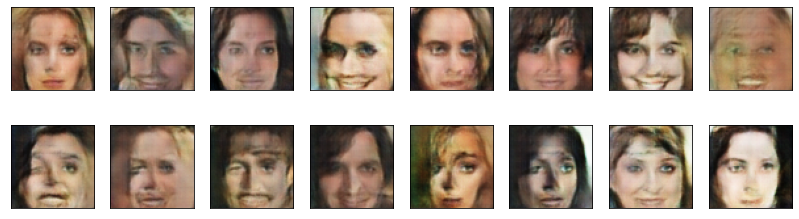

2023-08-06 04:08:32 | Epoch [17/20] | Batch 0/509 | d_loss: 1.0857 | g_loss: 0.5201
2023-08-06 04:08:38 | Epoch [17/20] | Batch 50/509 | d_loss: 1.2632 | g_loss: 0.8677
2023-08-06 04:08:43 | Epoch [17/20] | Batch 100/509 | d_loss: 1.5792 | g_loss: 1.7231
2023-08-06 04:08:49 | Epoch [17/20] | Batch 150/509 | d_loss: 1.3150 | g_loss: 0.8163
2023-08-06 04:08:55 | Epoch [17/20] | Batch 200/509 | d_loss: 1.4267 | g_loss: 0.9408
2023-08-06 04:09:00 | Epoch [17/20] | Batch 250/509 | d_loss: 1.3958 | g_loss: 1.2456
2023-08-06 04:09:06 | Epoch [17/20] | Batch 300/509 | d_loss: 1.3806 | g_loss: 0.9780
2023-08-06 04:09:12 | Epoch [17/20] | Batch 350/509 | d_loss: 1.5744 | g_loss: 1.6421
2023-08-06 04:09:18 | Epoch [17/20] | Batch 400/509 | d_loss: 1.3691 | g_loss: 0.9057
2023-08-06 04:09:24 | Epoch [17/20] | Batch 450/509 | d_loss: 1.2561 | g_loss: 0.9347
2023-08-06 04:09:29 | Epoch [17/20] | Batch 500/509 | d_loss: 1.2447 | g_loss: 0.7920


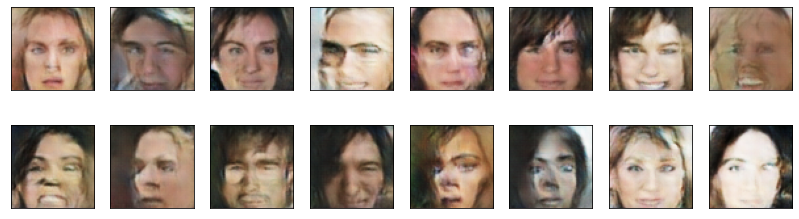

2023-08-06 04:09:33 | Epoch [18/20] | Batch 0/509 | d_loss: 1.3666 | g_loss: 1.2311
2023-08-06 04:09:39 | Epoch [18/20] | Batch 50/509 | d_loss: 1.2983 | g_loss: 1.1303
2023-08-06 04:09:45 | Epoch [18/20] | Batch 100/509 | d_loss: 1.3046 | g_loss: 0.6023
2023-08-06 04:09:50 | Epoch [18/20] | Batch 150/509 | d_loss: 1.2819 | g_loss: 0.9470
2023-08-06 04:09:56 | Epoch [18/20] | Batch 200/509 | d_loss: 1.1124 | g_loss: 0.5863
2023-08-06 04:10:02 | Epoch [18/20] | Batch 250/509 | d_loss: 1.1784 | g_loss: 1.1678
2023-08-06 04:10:08 | Epoch [18/20] | Batch 300/509 | d_loss: 1.4314 | g_loss: 1.0944
2023-08-06 04:10:13 | Epoch [18/20] | Batch 350/509 | d_loss: 1.2767 | g_loss: 1.2183
2023-08-06 04:10:19 | Epoch [18/20] | Batch 400/509 | d_loss: 1.3253 | g_loss: 1.0032
2023-08-06 04:10:25 | Epoch [18/20] | Batch 450/509 | d_loss: 1.2187 | g_loss: 0.8063
2023-08-06 04:10:30 | Epoch [18/20] | Batch 500/509 | d_loss: 1.3948 | g_loss: 0.8272


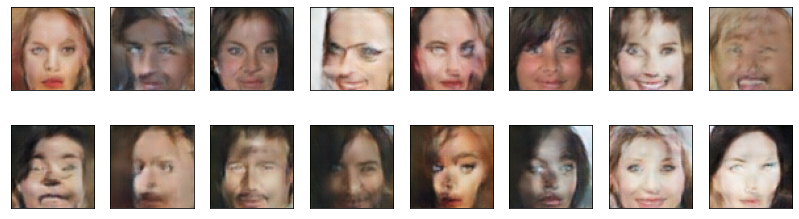

2023-08-06 04:10:37 | Epoch [19/20] | Batch 0/509 | d_loss: 1.3407 | g_loss: 1.2033
2023-08-06 04:10:43 | Epoch [19/20] | Batch 50/509 | d_loss: 1.2793 | g_loss: 0.9985
2023-08-06 04:10:49 | Epoch [19/20] | Batch 100/509 | d_loss: 1.3327 | g_loss: 0.9836
2023-08-06 04:10:54 | Epoch [19/20] | Batch 150/509 | d_loss: 1.4003 | g_loss: 1.2531
2023-08-06 04:11:00 | Epoch [19/20] | Batch 200/509 | d_loss: 1.3366 | g_loss: 1.1151
2023-08-06 04:11:06 | Epoch [19/20] | Batch 250/509 | d_loss: 1.2853 | g_loss: 1.0386
2023-08-06 04:11:12 | Epoch [19/20] | Batch 300/509 | d_loss: 1.4295 | g_loss: 0.9969
2023-08-06 04:11:17 | Epoch [19/20] | Batch 350/509 | d_loss: 1.1537 | g_loss: 0.9501
2023-08-06 04:11:23 | Epoch [19/20] | Batch 400/509 | d_loss: 1.4102 | g_loss: 1.0332
2023-08-06 04:11:29 | Epoch [19/20] | Batch 450/509 | d_loss: 1.3012 | g_loss: 0.9308
2023-08-06 04:11:35 | Epoch [19/20] | Batch 500/509 | d_loss: 1.3378 | g_loss: 1.1311


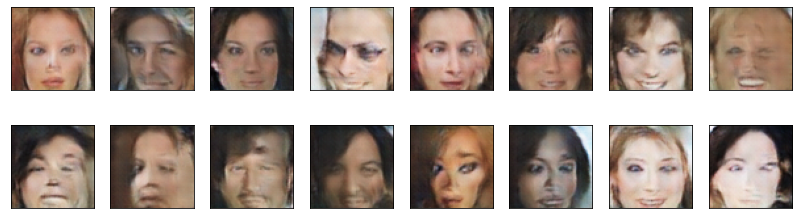

2023-08-06 04:11:39 | Epoch [20/20] | Batch 0/509 | d_loss: 1.2639 | g_loss: 1.0698
2023-08-06 04:11:45 | Epoch [20/20] | Batch 50/509 | d_loss: 1.3900 | g_loss: 1.0151
2023-08-06 04:11:51 | Epoch [20/20] | Batch 100/509 | d_loss: 1.4874 | g_loss: 1.0296
2023-08-06 04:11:56 | Epoch [20/20] | Batch 150/509 | d_loss: 1.2948 | g_loss: 1.0423
2023-08-06 04:12:02 | Epoch [20/20] | Batch 200/509 | d_loss: 1.2146 | g_loss: 1.0050
2023-08-06 04:12:08 | Epoch [20/20] | Batch 250/509 | d_loss: 1.4119 | g_loss: 0.9919
2023-08-06 04:12:14 | Epoch [20/20] | Batch 300/509 | d_loss: 1.2277 | g_loss: 0.8059
2023-08-06 04:12:20 | Epoch [20/20] | Batch 350/509 | d_loss: 1.2480 | g_loss: 0.9473
2023-08-06 04:12:25 | Epoch [20/20] | Batch 400/509 | d_loss: 1.3368 | g_loss: 1.0180
2023-08-06 04:12:31 | Epoch [20/20] | Batch 450/509 | d_loss: 1.2875 | g_loss: 1.0022
2023-08-06 04:12:37 | Epoch [20/20] | Batch 500/509 | d_loss: 1.3039 | g_loss: 0.8687


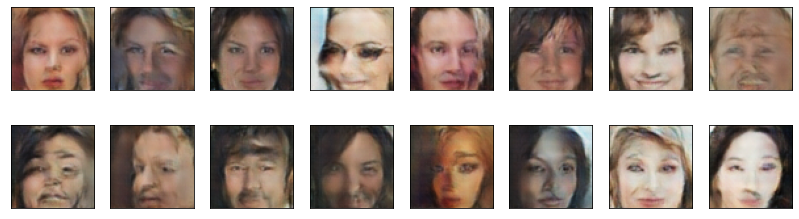

In [27]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        # 1. train discriminator
        if batch_i % 2 == 0: # to train the generator more then the discriminator
            d_loss = discriminator_step(batch_size, latent_dim, real_images)
            
        # 2. train generator
        g_loss = generator_step(batch_size, latent_dim)
    
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

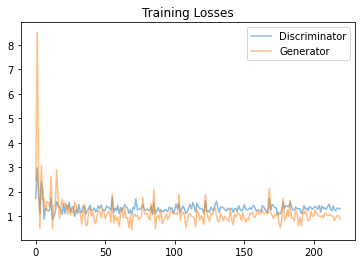

In [28]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:**
### General Observations

For this project, I have used the CelebFaces Attributes (CelebA) dataset to train my adversial network to obtain fairly realistic faces. A batch size of 509 is chosen and the discriminator and generator losses are printed out for every 50th batch. Additionally for each epoch, 16 generated image samples are displayed for inspection.

For each of the 16 images, the generated face morphs depending on the facial features such as: glasses, wearing hat, bangs, wavy hair, pointy nose, mustache, oval face and type of smile. Also, I noticed that there is a tendency that the face morphs to female feature like fairer skin, pink lips and blonde hair and manifests attractive female model appearances, but gets distorted when male features are added like mustache. Unlike humans who can tell when a generated face is realistic enough to stop adding new features, an otherwise good looking face continues to morph and evolve, until all the epoch runs are complete. As for the quantitative metrics of discriminator and generator losses, the values stabilizes with increasing number of epochs.

### GANs model description

**Issues with GAN convergence**
As mentioned in the lectures, GAN models are notoriously difficult to train, given the oscillating nature of the loss of both the generator and the discriminator. For example, there are larger spikes in the generator loss. However, both losses tend to stabilize over time. I have used the Binary Cross Entropy with Logits for the loss criterion.

To improve the model stability, I have implemented the gradient penalty which enforces the Lipschitz constraint. I have also used a lambda gradient penalty of 0.5 (less than 1), to emphasize less on the gradient penalty compared to the adversarial loss. This might have improve the model stability over time.

I have also tested the Wasserstein GAN, which is a meaningful loss metric that correlates with generator's convergence and sample quality. This is accomplished by using `d_loss_real = -real_logits.mean() ` and `d_loss_fake = fake_logits.mean()`, instead of the Binary Cross Entropy (BCE). However, the generated samples were not as good as the case when I used BCE. The reason could be that the celebrities featured in the dataset is very diverse, ranging from female models to seasoned male protagonists wearing accesories like darkened glasses. The labeled dataset is either real or fake, so it is no wonder it is hard for the model to discern real from fake. Humans are better at distinguishing real humans from fake as it is easy to tell that a male or female with irrelevant features is more likely fake. This is not obvious for the model.

### Future Improvements
The authors of the WGAN paper show that in order for the Wasserstein loss function to work, an additional constraint has to be in place on the critic. This constraint is called the Lipschitz constraint. The constraint is given by $\frac{\lVert D(x_1) - D(x_2) \rVert}{\lVert x_1 - x_2 \rVert} \le 1$, where $\lVert x_1 - x_2 \rVert$ is the average pixelwise absolute difference between two images and $\lVert D(x_1) - D(x_2) \rVert$ is the absolute difference between the critic prediction, Essentially, the rate at which the predictions of the critic can change between two images is capped or at a limit of 1. I guess that implementing this loss function will be appropriate if the model is trained for more epochs, since the loss for first 10 epochs is shown to be relatively noisy compared to BCE. Also more epochs and a deeper neural network or using models with pretrained weights will be beneficial given that there are many facial features to learn from. I mean that it may require more epochs and deeper neural network for the model to discern a mustache on a female 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.